In [1]:
using Random
using Distributions
using Plots

Random.seed!(1234);
rng = MersenneTwister(1234);
gr();

In [2]:
include("../neural_network/layer.jl");
include("../neural_network/cost_function.jl");
include("../neural_network/neural_network.jl");

In [3]:
function create_toy_data(func, sample_size, domain=[0.0, 1.0], noise=0.1)
    x = collect(range(domain[1], stop=domain[2], length=sample_size))
    shuffle!(rng, x);
    noise = rand(Uniform(-noise, noise), sample_size);
    return x, func.(x) + noise
end

function func(x)
    2.0 * x + 0.7 * sin(2 * pi * x)
end

function square(x)
    return x^2
end

function sinusoidal(x)
    return sin(pi * x)
end

function absolute(x)
    if x >= 0.0
        return x
    else
        return -x
    end
end

function heaviside(x)
    sign_x = x / absolute(x)
    return 0.5 * (sign_x + 1.0)
end

heaviside (generic function with 1 method)

## Back propagation

Each node transforms input as follows.

$$
\boldsymbol{x} \in \mathbb{R}^{\mathrm{input}} \longrightarrow \boldsymbol{z} = W \boldsymbol{x} + \boldsymbol{b} \in \mathbb{R}^{\mathrm{output}} \longrightarrow \boldsymbol{y} = f(\boldsymbol{z}) \in \mathbb{R}^{\mathrm{output}}
$$

The inputs and outputs may consist of several samples, i.e. $\boldsymbol{x} = [\boldsymbol{x}_1 \boldsymbol{x}_2 \cdots \boldsymbol{x}_N]$, $\boldsymbol{z} = [\boldsymbol{z}_1 \boldsymbol{z}_2 \cdots \boldsymbol{z}_N]$. But the size of samples does not affect the update process for $W, \boldsymbol{b}$.

So $W \in \mathbb{R}^{\mathrm{output} \times \mathrm{input}}$. In forward propagation, each node stores the values of $\boldsymbol{x}$ and $\boldsymbol{z}$.

Then given $\partial E / \partial \boldsymbol{y}$ at the end,

$$\begin{align*}
\dfrac{\partial E}{\partial \boldsymbol{z}} &= \dfrac{\partial E}{\partial \boldsymbol{y}} \odot f^{\prime}(\boldsymbol{z}) = \left[ \dfrac{\partial E}{\partial \boldsymbol{z}_1}, \dfrac{\partial E}{\partial \boldsymbol{z}_2}, \cdots, \dfrac{\partial E}{\partial \boldsymbol{z}_N} \right] \in \mathbb{R}^{\mathrm{output}} \\
\dfrac{\partial E}{\partial W} &= \dfrac{\partial E}{\partial \boldsymbol{z}} \boldsymbol{x}^{\text{T}} \in \mathbb{R}^{\mathrm{output}} \times \mathbb{R}^{\mathrm{input}} \\
\dfrac{\partial E}{\partial \boldsymbol{b}} &= \sum_{i} \dfrac{\partial E}{\partial \boldsymbol{z}_i} \in \mathbb{R}^{\mathrm{output}} \\
\dfrac{\partial E}{\partial \boldsymbol{x}} &= \boldsymbol{W}^{\text{T}} f^{\prime}(\boldsymbol{z}) \in \mathbb{R}^{\mathrm{input}}
\end{align*}$$

## Optimizer

### SGD

$$\begin{align}
\boldsymbol{g}_t &= \nabla E(\boldsymbol{w}_t) \\
\Delta \boldsymbol{w}_t &= -\eta \boldsymbol{g}_t \\
\boldsymbol{w}_{t+1} &= \boldsymbol{w}_t + \Delta \boldsymbol{w}_t
\end{align}$$

### Momentum SGD

$$\begin{align}
\boldsymbol{g}_t &= \nabla E(\boldsymbol{w}_t) \\
\Delta \boldsymbol{w}_t &= \mu \Delta \boldsymbol{w}_{t-1} - (1 - \mu) \eta \boldsymbol{g}_t \\
\boldsymbol{w}_{t+1} &= \boldsymbol{w}_t + \Delta \boldsymbol{w}_t
\end{align}$$

### RMSProp

$$\begin{align}
\boldsymbol{g}_t &= \nabla E(\boldsymbol{w}_t) \\
\boldsymbol{v}_t &= \rho \boldsymbol{v}_{t-1} + (1 - \rho) \boldsymbol{g}^{2}_{t} \\
\Delta \boldsymbol{w}_t &= -\dfrac{\eta}{\sqrt{\boldsymbol{v}_t + \epsilon}} \boldsymbol{g}_t \\
\boldsymbol{w}_{t+1} &= \boldsymbol{w}_t + \Delta \boldsymbol{w}_t
\end{align}$$

### Adam

$$\begin{align}
\boldsymbol{g}_t &= \nabla E(\boldsymbol{w}_t) \\
\boldsymbol{m}_t &= \rho_1 \boldsymbol{m}_{t-1} + (1 - \rho_1) \boldsymbol{g}_{t} \\
\boldsymbol{v}_t &= \rho_2 \boldsymbol{v}_{t-1} + (1 - \rho_2) \boldsymbol{g}^{2}_{t} \\
\hat{\boldsymbol{m}}_t &= \dfrac{\boldsymbol{m}_t}{1 - \rho_1} \\
\hat{\boldsymbol{v}}_t &= \dfrac{\boldsymbol{v}_t}{1 - \rho_2} \\
\Delta \boldsymbol{w}_t &= -\dfrac{\eta}{\sqrt{\hat{\boldsymbol{v}}_t + \epsilon}} \hat{\boldsymbol{m}}_t \\
\boldsymbol{w}_{t+1} &= \boldsymbol{w}_t + \Delta \boldsymbol{w}_t
\end{align}$$

## Function approximation

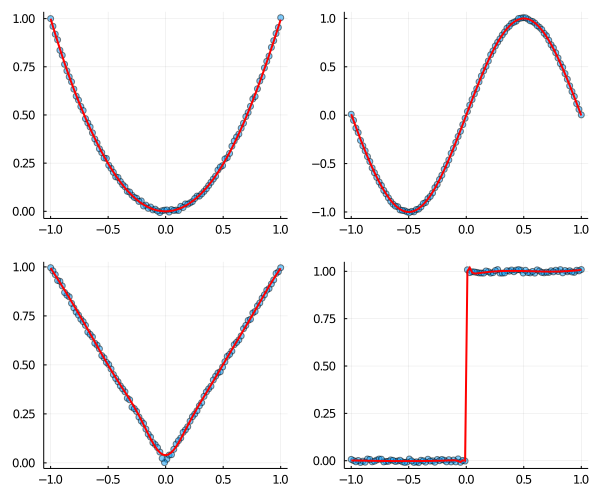

In [4]:
layers = [TanhLayer(1, 4), TanhLayer(4, 3), LinearLayer(3, 1)];
cost_function = SumSquareError();
nn = NeuralNetwork(layers, cost_function);

toy_functions = [square, sinusoidal, absolute, heaviside];
domain = [-1.0, 1.0];

plots = [];
for toy_func in toy_functions
    x_train, y_train = create_toy_data(toy_func, 100, domain, 0.01);
    X = collect(reshape(x_train, 1, 100));
    t = collect(reshape(y_train, 1, 100));

    for i in 1:30000
        X = collect(reshape(x_train, 1, 100));
        t = collect(reshape(y_train, 1, 100));
    
        fitting(nn, X, t, 0.001);
    end

    x_test = collect(reshape(range(domain[1], domain[2], length=100), 1, 100));
    X_test = copy(x_test);
    X_test = predict(nn, X_test);

    x_test = collect(reshape(x_test, 100));
    X_test = collect(reshape(X_test, 100));
    p = plot(x_train, y_train, seriestype=:scatter, alpha=0.5);
    p = plot!(x_test, X_test, legend=nothing, lw=2, color="red");
    push!(plots, p);
end

plot(plots[1], plots[2], plots[3], plots[4], layout=(2, 2), size=(600, 500))

## Binary classification with neural networks

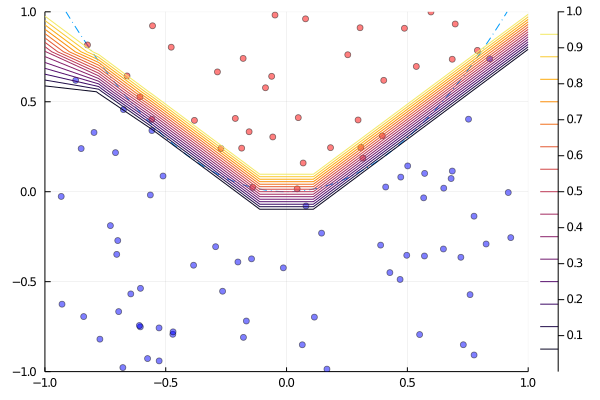

In [5]:
# input: [x, y] ∈ [-1, 1] x [-1, 1] --> output: {0, 1}
## Data generation
n_samples = 100
points = rand(2, n_samples)
points = points .* 2 .- 1.0

function boundary(x)
    return 1.2 .* x .* x
end

targets = [boundary(points[1, i]) < points[2, i] for i in 1:n_samples] * 1.0

p = plot()
x_test = collect(range(-1.0, stop=1.0, length=100));
p = plot!(x_test, boundary(x_test), style=:dashdot)
for i in 1:n_samples
    if targets[i] == 1.0
        p = scatter!([points[1, i]], [points[2, i]], seriestype=:scatter, alpha=0.5, color="red")
    else
        p = scatter!([points[1, i]], [points[2, i]], seriestype=:scatter, alpha=0.5, color="blue")
    end
end

## Classification
layers = [TanhLayer(2, 2), SigmoidLayer(2, 1)];
cost_function = SigmoidCrossEntropy()
targets = collect(reshape(targets, 1, n_samples))
nn = NeuralNetwork(layers, cost_function)

### Training
n_training = 5000
for i in 1:n_training
    fitting(nn, points, targets, 0.001)
end

### Contour of nn prediction
x = collect(range(-1.0, stop=1.0, length=10));
y = collect(range(-1.0, stop=1.0, length=10));
val = [predict(nn, reshape([i, j], 2, 1))[1] for j in y, i in x];
p = contour!(x, y, val, vel_value=0.5)
plot(p, xlims=(-1, 1), ylims=(-1, 1), legend=nothing)

## Regularization of neural networks

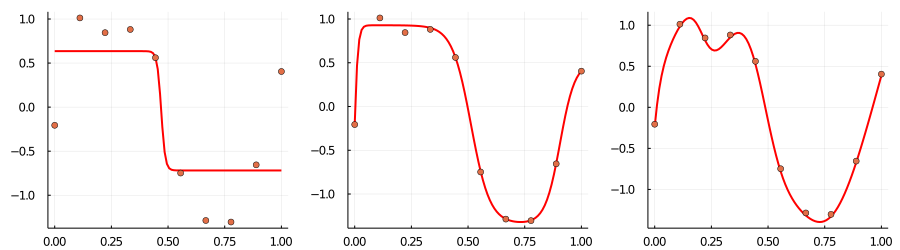

In [6]:
function gen_toy_data(n=10)
    x = collect(range(0.0, stop=1.0, length=n));
    y = sin.(2 * pi * x) + rand(Normal(0, 0.25), n)
    return x, y
end

x_train, y_train = gen_toy_data(10);
plots = [];
for i in [1, 3, 30]
    X = collect(reshape(x_train, 1, 10));
    t = collect(reshape(y_train, 1, 10));
    layers = [TanhLayer(1, i), LinearLayer(i, 1)];
    cost_function = SumSquareError();
    nn = NeuralNetwork(layers, cost_function);
    for _ in 1:40000
        fitting(nn, X, t, 0.01);
    end
    
    X_test = collect(reshape(range(0.0, stop=1.0, length=100), 1, 100));
    t_test = predict(nn, X_test);
    X_test = collect(reshape(X_test, 100));
    t_test = collect(reshape(t_test, 100));
    p = plot(X_test, t_test, lw=2, color="red");
    p = plot!(x_train, y_train, seriestype=:scatter);
    push!(plots, p);
end
plot(plots[1], plots[2], plots[3], layout=(1, 3), size=(300*3, 250*1), legend=nothing)

## Mixture density network

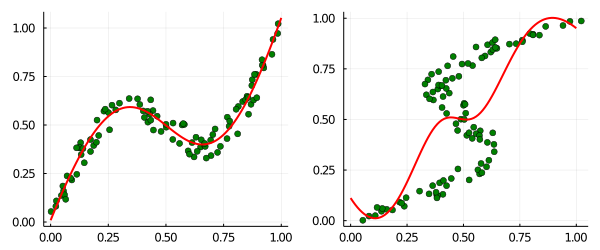

In [7]:
n_samples = 100
function toy_func(x)
    return x .+ 0.3 * sin.(2 * pi * x)
end
#x_lin = collect(reshape(range(0.0, stop=1.0, length=100), 100))
x_train = collect(reshape(rand(n_samples), 1, n_samples))
y_train = toy_func(x_train) .+ rand(Uniform(-0.08, 0.08), 1, n_samples)
y_train = collect(reshape(y_train, 1, n_samples))

# forward
## Regression
layers = [TanhLayer(1, 6), LinearLayer(6, 1)];
cost_function = SumSquareError()
nn = NeuralNetwork(layers, cost_function)
for i in 1:5000
    fitting(nn, x_train, y_train, 0.001)
end

plots = []
x_test = collect(reshape(range(0, 1.0, length=100), 1, 100));
y_test = predict(nn, x_test)
x_test = collect(reshape(x_test, 100))
y_test = collect(reshape(y_test, 100))
p = plot(x_train, y_train, seriestype=:scatter, legend=nothing, color="green")
p = plot!(x_test, y_test, lw=2, color="red")
push!(plots, p)
#p = plot!(x_lin, toy_func(x_lin), style=:dashdot)
x_train, y_train = y_train, x_train
nn = NeuralNetwork(layers, cost_function)
for i in 1:5000
    fitting(nn, x_train, y_train, 0.001)
end
x_test = collect(reshape(range(0, 1.0, length=100), 1, 100));
y_test = predict(nn, x_test)
x_test = collect(reshape(x_test, 100))
y_test = collect(reshape(y_test, 100))
p = plot(x_train, y_train, seriestype=:scatter, legend=nothing, color="green")
p = plot!(x_test, y_test, lw=2, color="red")
push!(plots, p)

plot(plots[1], plots[2], layout=(1, 2), size=(300*2, 250*1), legend=nothing)

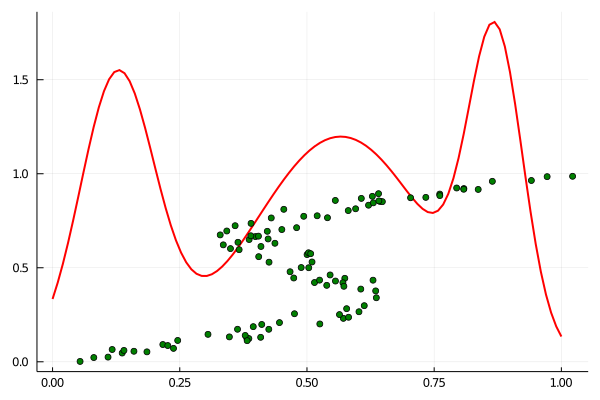

In [8]:
# Not working.
function mixture_gaussian(x::Float64, mus::AbstractArray{Float64, 1}, sigma2s::AbstractArray{Float64, 1}, pis::AbstractArray{Float64, 1})
    ret = 0.0
    for k in 1:size(mus)[1]
        ret += pis[k] * exp(-(x - mus[k])^2 / (2 * sigma2s[k])) / sqrt(2.0 * pi * sigma2s[k])
    end
    return ret
end

function sample(x::AbstractArray{Float64, 2}, n_samples)
    x_size = size(x)[2]
    indices = rand(1:x_size, n_samples)
    return x[:, indices]
end

layers = [TanhLayer(1, 5), LinearLayer(5, 9)];
mixture_function = GaussianMixtureError(3);
nn = NeuralNetwork(layers, mixture_function);
learning_rate = 0.001
for i in 1:100000
    X = sample(x_train, 70)
    t = sample(y_train, 70)
    for layer in nn.layers
        X = forward_propagation(layer, X)
    end
    
    diff = delta(mixture_function, X, t)
    for layer in reverse(nn.layers)
        diff = backward_propagation(layer, diff, learning_rate)
    end
end

x_test = collect(reshape(range(0, 1.0, length=100), 1, 100));
output = copy(x_test)
for layer in nn.layers
    output = forward_propagation(layer, output)
end

for n in 1:100
    pis = view(output, 1:3, n)
    mus = view(output, 4:6, n)
    sigma2s = view(output, 7:9, n)
    
    # (1) convert output to [pis, mus, sigma2s]
    # pis
    max_pi = maximum(pis)
    for k in 1:3
        pis[k] = pis[k] - max_pi
    end
    for k in 1:3
        pis[k] = exp(pis[k])
    end
    sum_pis = sum(pis)
    for k in 1:3
        pis[k] /= sum_pis
    end
    # sigma2s
    for k in 1:3
        sigma2s[k] = exp(sigma2s[k])^2
    end
end

y_test = [mixture_gaussian(x_test[1, i], output[4:6, i], output[7:9, i], output[1:3, i]) for i in 1:100]
x_test = collect(reshape(x_test, 100))
y_test = collect(reshape(y_test, 100))
plot(x_test, y_test, lw=2, legend=nothing, color="red")
plot!(x_train[1, :], y_train[1, :], seriestype=:scatter, legend=nothing, color="green")